In [319]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.spatial import KDTree

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from tools.log_progress import log_progress

coords_path = os.path.join(data_dir,'analysis','external','antbounds','shelves2.mat')
int_dir = os.path.join(data_dir,'analysis','interim')
pro_dir = os.path.join(data_dir,'analysis','processed')
fig_dir = os.path.join(os.pardir,os.pardir,'reports','figures')
grid_path = os.path.join(data_dir,'preprocessing','processed','waom2_grd.nc')
avg_path = os.path.join(data_dir,'analysis','raw','waom2','m.nc')

# All ice in the model (Bedmap2)

In [321]:
grd = xr.open_dataset(grid_path)

avg = xr.open_dataset(avg_path)

m = avg.m.mean('ocean_time')

s2a = 3600*24*365.25
rhoi = 916

In [332]:
all_ice = {}

ice_shelf = (grd.mask_rho==1) & (grd.zice<0.0) 
vostock = (grd.lat_rho<-75) & (grd.lat_rho>-80) & (grd.lon_rho>95) & (grd.lon_rho<115)

mask = ice_shelf & ~vostock

dA = (1/(grd.pm*grd.pn)).where(mask)
weights = dA/dA.sum()

dA_l = dA.where(m > 0.0)
weights_l = dA_l/dA.sum()

dA_g = dA.where(m < 0.0)
weights_g = dA_g/dA.sum()

ismr2bmb = dA*rhoi*(10**-12)

all_ice["A"] = dA.sum().values*10**-9
all_ice["ismr"] = (m.where(mask)*weights).sum().values*s2a
all_ice["ismr_l"] = (m.where(mask & (m > 0.0))*weights_l).sum().values*s2a
all_ice["ismr_g"] = (m.where(mask & (m < 0.0))*weights_g).sum().values*s2a
all_ice["bmb"] = (m.where(mask)*ismr2bmb).sum().values*s2a
all_ice["bml"] = (m.where(mask & (m > 0.0))*ismr2bmb).sum().values*s2a
all_ice["bmg"] = (m.where(mask & (m < 0.0))*ismr2bmb).sum().values*s2a
all_ice['ismr_max'] = m.where(mask).max().values*s2a
all_ice['ismr_min'] = m.where(mask).min().values*s2a

all_ice = pd.DataFrame.from_dict({'all_ice':all_ice}, orient='index',
                            columns=['bmb','ismr','A','bml','bmg','ismr_l','ismr_g','ismr_max','ismr_min']).dropna()
all_ice

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
all_ice,"1,209.20",0.82,"1,617.62","1,264.06",-54.86,0.85,-0.04,63.18,-16.92


## All ice shelves from antbound

In [23]:
# read in ice shelf coordinates derived from ant_bounds matlab package
coords = sio.loadmat(coords_path)['shelves'][0].squeeze()

shelves = {}
for idx in range(np.size(coords)):
    name = coords[idx][0][0]
    shelves[name]={}
    shelves[name]['lat']= coords[idx][1].squeeze()
    shelves[name]['lon']= coords[idx][2].squeeze()

In [24]:
# find nearest neighbours of ant_bounds lat_lon coords on the roms grid and 
# define ice shelf masks and middle coordinates
grd = xr.open_dataset(grid_path)

lat_flat = grd.lat_rho.stack(etaxi = ('eta_rho','xi_rho'))
lon_flat = grd.lon_rho.stack(etaxi = ('eta_rho','xi_rho'))
points = np.column_stack((lat_flat.values,lon_flat.values))
tree = KDTree(points)

for name,data in log_progress(shelves.items(),name='ice shelves'):
    
    lats = data['lat']
    lons = data['lon']

    target = np.column_stack((lats,lons))
    dist, ind = tree.query(target,k=1)
    
    eta = lat_flat[np.unique(ind)].eta_rho.values
    xi = lat_flat[np.unique(ind)].xi_rho.values
    shelves[name]['eta'] = eta
    shelves[name]['xi'] = xi
    
    mask_tmp = np.zeros_like(grd.mask_rho.values)
    mask_tmp[eta,xi] = 1
    mask_tmp[grd.zice.values == 0.0] = 0
    mask_tmp[grd.mask_rho.values == 0.0] = 0
    mask_tmp = (mask_tmp == 1)  
    shelves[name]['mask']=mask_tmp
    
    xi_m,eta_m = np.median(xi),np.median(eta)
    shelves[name]['xi_mid']=xi_m
    shelves[name]['eta_mid']=eta_m

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [168]:
#optional plot ice shelf masks and names
%matplotlib notebook

plt.close()
fig,ax = plt.subplots(figsize=(10,7))
grd.zice.where((grd.mask_rho==1)&(grd.zice<0)).plot(ax=ax,alpha=0.2,add_colorbar=False)

for name,data in log_progress(shelves.items()):
    
    grd.zice.where(data['mask']).plot(ax=ax,add_colorbar=False,alpha=0.5)
    ax.text(data['xi_mid'],data['eta_mid'],name,alpha=0.8)
    
ax.set_aspect('equal')
plt.tight_layout()

plt.show()

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [ ]:
#avg = xr.open_dataset(avg_path)

#m = avg.m.mean('ocean_time')

#s2a = 3600*24*365.25
#rhoi = 916

mask_ice = (grd.mask_rho==1) & (grd.zice<0)

for name,data in log_progress(shelves.items(),name='Ice shelf'): 

    mask = data['mask']

    dA = (1/(grd.pm*grd.pn)).where(mask)
    weights = dA/dA.sum()

    dA_l = dA.where(m > 0.0)
    weights_l = dA_l/dA.sum()

    dA_g = dA.where(m < 0.0)
    weights_g = dA_g/dA.sum()

    ismr2bmb = dA*rhoi*(10**-12)

    shelves[name]["A"] = dA.sum().values*10**-9
    shelves[name]["ismr"] = (m.where(mask)*weights).sum().values*s2a
    shelves[name]["ismr_l"] = (m.where(mask & (m > 0.0))*weights_l).sum().values*s2a
    shelves[name]["ismr_g"] = (m.where(mask & (m < 0.0))*weights_g).sum().values*s2a
    shelves[name]["bmb"] = (m.where(mask)*ismr2bmb).sum().values*s2a
    shelves[name]["bml"] = (m.where(mask & (m > 0.0))*ismr2bmb).sum().values*s2a
    shelves[name]["bmg"] = (m.where(mask & (m < 0.0))*ismr2bmb).sum().values*s2a
    shelves[name]['ismr_max'] = m.where(mask).max().values*s2a
    shelves[name]['ismr_min'] = m.where(mask).min().values*s2a

In [ ]:
dict_out_path = os.path.join(int_dir,'shelves2.npy')
np.save(dict_out_path,shelves)

In [ ]:
df = pd.DataFrame.from_dict(shelves, orient='index',
                            columns=['bmb','ismr','A','bml','bmg','ismr_l','ismr_g','ismr_max','ismr_min']).dropna()

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
df.to_csv(os.path.join(int_dir,'2km _mass_loss_ant_bounds_all.csv'))
df

In [ ]:
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()
    
def combine_shelves(df,name):
    
    new_data = {}
    
    for key in ['bmb','bml','bmg','A']:
        new_data[key]=df[key].sum()
    for key in ['ismr','ismr_l','ismr_g']:
        new_data[key]=wavg(df,key,'A')
        
    new_data['ismr_max']=df['ismr_max'].max()
    new_data['ismr_min']=df['ismr_min'].min()
    
    new_dict = {name:{'bmb':new_data['bmb'],'ismr':new_data['ismr'],'A':new_data['A'],
                      'bml':new_data['bml'],'bmg':new_data['bmg'],
                      'ismr_l':new_data['ismr_l'],'ismr_g':new_data['ismr_g'],
                      'ismr_max':new_data['ismr_max'],'ismr_min':new_data['ismr_min']}}
    new_df = pd.DataFrame.from_dict(new_dict, orient='index',
                                    columns=['bmb','ismr','A','bml','bmg',
                                             'ismr_l','ismr_g','ismr_max','ismr_min'])
    
    return new_df

In [ ]:
ant_bounds_comb = combine_shelves(df,'All ant_bounds')
ant_bounds_comb

# following Rignot 2013

In [ ]:
def select_names(df,names):
    df_select = df[df.index.str.contains('bla')]
    for string in names:
        df_select = df_select.append(df[df.index.str.contains(string)])
    return df_select

In [ ]:
AP_names = ['LarsenG','LarsenF','LarsenE','LarsenD','LarsenC','LarsenB','Wordie','Wilkins','Bach','George VI','Stange']
select_names(df,AP_names)

In [ ]:
AP = pd.concat([select_names(df,['LarsenG','LarsenF','LarsenE']),
              combine_shelves(select_names(df,['LarsenD']),'Larsen D'),
              select_names(df,['LarsenC']),
              combine_shelves(select_names(df,['Wordie']),'Wordie'),
              select_names(df,['Wilkins','Bach','George VI','Stange'])])
AP

In [ ]:
AP_comb = combine_shelves(AP,'AP')
AP_comb

In [ ]:
WAIS_names = ['Ronne','Ferrigno','Venable','Abbot','Cosgrove','Pine Island','Thwaites','Crosson','Dotson','Getz',
              'Land','Nickerson','Sulzberger','Swinburne','Withrow','Ross West']
select_names(df,WAIS_names)

In [ ]:
WAIS = pd.concat([select_names(df,['Ronne','Ferrigno','Venable']),
              combine_shelves(select_names(df,['Abbot']),'Abbot'),
              select_names(df,['Cosgrove','Pine Island','Thwaites','Crosson','Dotson']),
              combine_shelves(select_names(df,['Getz']),'Getz'),
              select_names(df,['Nickerson','Sulzberger','Swinburne','Withrow','Ross West'])])
WAIS

In [ ]:
WAIS_comb = combine_shelves(WAIS,'WAIS')
WAIS_comb

In [ ]:
EAIS_names = ['Ross East','Drygalski','Nansen','Aviator','Mariner','Lillie','Rennick','Cook','Ninnis','Mertz',
              'Dibble','Holmes','Moscow University','Totten','Vincennes','Conger','Tracy','Shackleton','West',
              'Publications','Amery','Wilma','Edward','Rayner','Shirase','Prince Harald','Baudouin','Borchgrevink',
              'Lazarev','Nivl','Vigrid','Fimbul','Jelbart','Atka','Ekstrom','Quar','Riiser','Brunt','Filchner']
select_names(df,EAIS_names)

In [ ]:
EAIS = select_names(df,EAIS_names).drop('Ross West')
EAIS

In [ ]:
EAIS_comb = combine_shelves(EAIS,'EAIS')
EAIS_comb

In [ ]:
Rignot_comb = combine_shelves(pd.concat([AP_comb,WAIS_comb,EAIS_comb]),'Rignot all')
Rignot_comb

In [317]:
df_out = pd.concat([AP,AP_comb,
           WAIS,WAIS_comb,
           EAIS,EAIS_comb,
           Rignot_comb,
           ant_bounds_comb,
           all_ice])
df_out.to_

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
LarsenG,0.05,0.13,0.39,0.06,-0.01,0.16,-0.03,0.49,-0.38
LarsenF,0.23,0.32,0.79,0.27,-0.04,0.38,-0.06,2.92,-0.81
LarsenE,0.87,0.82,1.15,1.00,-0.13,0.94,-0.12,6.15,-1.63
Larsen D,5.50,0.28,21.68,6.92,-1.42,0.35,-0.07,3.78,-2.59
LarsenC,9.08,0.22,45.62,10.14,-1.06,0.24,-0.03,4.95,-2.74
Wordie,0.05,0.19,0.27,0.05,-0.00,0.19,-0.00,0.52,-0.02
Wilkins,15.85,1.36,12.70,15.86,-0.01,1.36,-0.00,9.23,-0.38
Bach,12.92,3.14,4.49,12.99,-0.07,3.16,-0.02,42.62,-3.51
George VI,145.99,6.99,22.79,146.02,-0.03,7.00,-0.00,50.14,-3.52
Stange,14.71,2.06,7.80,14.71,-0.00,2.06,-0.00,12.54,-0.01


In [311]:
total_ant.to_csv(os.path.join(pro_dir,'2km_mass_loss_Rignot_all.csv'))

# Major ice shelves for comparison

In [245]:
names = ['George','Abbot','Pine','Getz','Fimbul','Jelbart','Brunt','Riiser','Filchner','Ronne','LarsenC','Ross',
                   'Totten','Moscow','Shackleton','Amery']
major = select_names(df,names)     

In [246]:
def merge_shelves(df,name1,name2,name):
    
    p1 = df.loc[name1]
    p2 = df.loc[name2]
    
    new_data = {}
    for key in ['bmb','bml','bmg','A']:
        new_data[key]=p1[key]+p2[key]
    for key in ['ismr','ismr_l','ismr_g']:
        new_data[key]=(p1[key]*p1['A']+p2[key]*p2['A'])/(p1['A']+p2['A'])
        
    new_data['ismr_max']=np.max([p1['ismr_max'],p2['ismr_max']])
    new_data['ismr_min']=np.max([p1['ismr_min'],p2['ismr_min']])
    
    new_dict = {name:{'bmb':new_data['bmb'],'ismr':new_data['ismr'],'A':new_data['A'],
                      'bml':new_data['bml'],'bmg':new_data['bmg'],
                      'ismr_l':new_data['ismr_l'],'ismr_g':new_data['ismr_g'],
                      'ismr_max':new_data['ismr_max'],'ismr_min':new_data['ismr_min']}}
    new_df = pd.DataFrame.from_dict(new_dict, orient='index',columns=['bmb','ismr','A','bml','bmg','ismr_l','ismr_g','ismr_max','ismr_min'])
    df = df.drop([name1,name2])
    df = df.append(new_df)
    
    return df

In [247]:
major = merge_shelves(major,'Abbot','Abbot 1','Abbot')
for key in ['2','3','4','5','6']:
    major = merge_shelves(major,'Abbot','Abbot '+key,'Abbot')
major

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
George VI,145.99,6.99,22.79,146.02,-0.03,7.00,-0.00,50.14,-3.52
Pine Island,36.65,7.03,5.69,36.65,-0.00,7.04,-0.00,63.13,-0.19
Getz,59.76,2.00,32.54,60.12,-0.36,2.02,-0.01,21.69,-2.06
Getz 1,0.36,0.78,0.51,0.36,0.00,0.78,0.00,2.70,0.04
Fimbul,53.89,1.47,39.92,53.95,-0.06,1.48,-0.00,24.58,-3.12
Jelbart,9.04,0.93,10.61,9.36,-0.31,0.96,-0.03,11.70,-1.18
Brunt Stancomb,33.52,1.02,36.00,33.69,-0.17,1.02,-0.01,19.07,-0.53
Riiser-Larsen,31.01,0.79,42.85,32.51,-1.50,0.83,-0.04,17.51,-5.67
Filchner,6.19,0.07,100.95,13.31,-7.12,0.14,-0.08,8.00,-5.25
Ronne,84.05,0.28,332.38,105.28,-21.23,0.35,-0.07,19.54,-14.55


In [248]:
major = merge_shelves(major,'Filchner','Ronne','Filchner-Ronne')
major = merge_shelves(major,'Getz','Getz 1','Getz')
major = merge_shelves(major,'Fimbul','Jelbart','Fimbul + Jelbart')
major = merge_shelves(major,'Brunt Stancomb','Riiser-Larsen','Brunt + Riiser-Larsen')
major = merge_shelves(major,'Ross East','Ross West','Ross')
major = merge_shelves(major,'Totten','Moscow University','Totten + Moscow Uni')

In [249]:
major

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
George VI,145.99,6.99,22.79,146.02,-0.03,7.00,-0.00,50.14,-3.52
Pine Island,36.65,7.03,5.69,36.65,-0.00,7.04,-0.00,63.13,-0.19
LarsenC,9.08,0.22,45.62,10.14,-1.06,0.24,-0.03,4.95,-2.74
Shackleton,17.12,0.74,25.26,18.29,-1.18,0.79,-0.05,10.81,-2.15
Amery,10.56,0.19,59.13,16.63,-6.07,0.31,-0.11,9.04,-16.91
Abbot,73.63,2.60,30.90,73.63,-0.00,2.60,-0.00,17.35,0.17
Filchner-Ronne,90.25,0.23,433.32,118.60,-28.35,0.30,-0.07,19.54,-5.25
Getz,60.12,1.99,33.05,60.48,-0.36,2.00,-0.01,21.69,0.04
Fimbul + Jelbart,62.94,1.36,50.54,63.31,-0.37,1.37,-0.01,24.58,-1.18
Brunt + Riiser-Larsen,64.53,0.89,78.86,66.20,-1.67,0.92,-0.02,19.07,-0.53


In [225]:
csv_select_pro_path = os.path.join(int_dir,'2km_mass_loss_major.csv')
major.to_csv(csv_select_pro_path)

In [201]:
major_comb = combine_shelves(major,'major')
major_comb

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
major,543.24,0.72,828.57,562.54,-19.31,0.74,-0.03,63.13,-16.91


# Major Ice shelves after ocean and size

In [203]:
names = ['George','Wilkins','Bach','Stange','Ferrigno',
        'Venable','Abbot','Cosgrove','Pine','Thwaits','Crosson',
         'Dotson','Getz','Land']
warm_AB = select_names(df,names)
warm_AB

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
George VI,145.99,6.99,22.79,146.02,-0.03,7.00,-0.00,50.14,-3.52
Wilkins,15.85,1.36,12.70,15.86,-0.01,1.36,-0.00,9.23,-0.38
Bach,12.92,3.14,4.49,12.99,-0.07,3.16,-0.02,42.62,-3.51
Stange,14.71,2.06,7.80,14.71,-0.00,2.06,-0.00,12.54,-0.01
Ferrigno,1.12,10.83,0.11,1.12,0.00,10.83,0.00,19.63,2.97
Venable,13.90,4.84,3.13,13.90,-0.00,4.84,-0.00,28.18,-0.22
Abbot,72.06,2.71,29.02,72.06,-0.00,2.71,-0.00,17.35,-0.07
Abbot 1,0.12,0.69,0.20,0.12,0.00,0.69,0.00,3.18,0.13
Abbot 2,0.19,0.71,0.29,0.19,-0.00,0.71,-0.00,4.33,-0.06
Abbot 3,0.16,0.60,0.30,0.16,0.00,0.60,0.00,3.29,0.13


In [230]:
warm_AB_comb = combine_shelves(warm_AB,'Amunden-Bellinghausen')
warm_AB_comb

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Amunden-Bellinghausen,390.94,3.23,132.15,391.87,-0.93,3.24,-0.01,63.13,-3.52


In [205]:
names = ['Filchner','Ronne','Ross','LarsenC','Amery']
large_cold = select_names(df,names)
large_cold

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Filchner,6.19,0.07,100.95,13.31,-7.12,0.14,-0.08,8.00,-5.25
Ronne,84.05,0.28,332.38,105.28,-21.23,0.35,-0.07,19.54,-14.55
Ross East,25.13,0.15,188.75,27.35,-2.22,0.16,-0.01,10.55,-2.51
Ross West,41.35,0.15,301.65,46.49,-5.14,0.17,-0.02,10.25,-1.76
LarsenC,9.08,0.22,45.62,10.14,-1.06,0.24,-0.03,4.95,-2.74
Amery,10.56,0.19,59.13,16.63,-6.07,0.31,-0.11,9.04,-16.91


In [207]:
large_cold_comb = combine_shelves(large_cold,'large cold')
large_cold_comb

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
large cold,176.36,0.19,"1,028.48",219.20,-42.84,0.23,-0.05,19.54,-16.91


In [180]:
names = ['Nickerson','Sulzberg','Swinburne','Withrow','Drygal','Nansen',
         'Aviator','Mariner']
small_RS = select_names(df,names)
small_RS

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Nickerson,22.29,3.83,6.35,22.29,-0.00,3.83,-0.00,16.03,-0.25
Sulzberger,40.90,3.73,11.96,40.90,-0.00,3.73,-0.00,25.68,-0.06
Swinburne,6.05,8.03,0.82,6.05,0.00,8.03,0.00,24.31,0.03
Withrow,0.96,1.69,0.62,0.96,0.00,1.69,0.00,4.49,0.14
Drygalski,1.75,0.85,2.24,1.82,-0.07,0.89,-0.04,6.25,-2.28
Nansen,0.14,0.08,1.86,0.28,-0.14,0.16,-0.08,1.13,-0.63
Aviator,0.24,0.34,0.77,0.27,-0.04,0.39,-0.05,1.35,-0.42
Mariner,1.73,0.71,2.65,1.88,-0.14,0.77,-0.06,7.56,-1.25


In [210]:
small_RS_comb = combine_shelves(small_RS,'Small Ross Sea')
small_RS_comb

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Small Ross Sea,74.06,2.97,27.27,74.45,-0.39,2.98,-0.02,25.68,-2.28


In [185]:
names = ['Lillie','Rennick','Cook','Mertz','Dibble',
         'Holmes','Moscow','Totten','Vincennes','Conger','Tremenchus',
        'Shackleton']
small_EI = select_names(df,names)
small_EI

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Lillie,1.68,2.49,0.74,1.69,-0.00,2.50,-0.01,14.62,-0.52
Rennick,0.73,0.25,3.21,1.09,-0.36,0.37,-0.12,2.47,-1.69
Cook,10.64,3.49,3.33,10.64,0.00,3.49,0.00,14.16,0.03
Mertz,6.60,1.36,5.31,6.73,-0.13,1.39,-0.03,6.54,-0.80
Dibble,3.29,2.55,1.41,3.29,-0.00,2.55,-0.00,11.67,-0.12
Holmes,3.36,1.71,2.14,3.36,0.00,1.71,0.00,8.36,0.03
Moscow University,6.41,1.23,5.68,7.75,-1.34,1.49,-0.26,10.46,-5.76
Totten,6.85,1.26,5.92,7.88,-1.03,1.45,-0.19,10.69,-6.12
Vincennes Bay,1.64,1.98,0.91,1.64,0.00,1.98,0.00,9.15,0.25
Conger Glenzer,5.02,3.58,1.53,5.02,0.00,3.58,0.00,9.94,0.62


In [211]:
small_EI_comb = combine_shelves(small_EI,'small East Indien')
small_EI_comb

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
small East Indien,65.48,1.23,58.16,69.63,-4.15,1.31,-0.08,14.62,-6.12


In [190]:
names = ['Vigrid','Nivl','Lazarev','Borch','Bau','Prince','Shirase',
         'Rayner','Edward','Wilma','Publications','West']
small_WI = select_names(df,names).drop('Ross West')
small_WI

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Vigrid,1.53,0.83,2.01,1.53,-0.00,0.83,-0.00,4.25,-0.05
Nivl,2.11,0.32,7.14,2.19,-0.08,0.33,-0.01,4.75,-0.81
Lazarev,3.05,0.40,8.35,3.22,-0.17,0.42,-0.02,3.66,-0.42
Borchgrevink,18.59,0.99,20.43,18.61,-0.01,0.99,-0.00,11.46,-0.48
Baudouin,17.93,0.60,32.37,17.94,-0.01,0.61,-0.00,5.51,-0.10
Prince Harald,5.81,1.25,5.06,5.81,0.00,1.25,0.00,6.56,0.03
Shirase,1.04,1.74,0.65,1.04,-0.00,1.74,-0.00,6.70,-0.04
Rayner Thyer,0.16,0.29,0.61,0.17,-0.01,0.30,-0.01,2.47,-0.16
Edward VIII,0.31,0.85,0.39,0.31,-0.00,0.85,-0.00,3.86,-0.00
WilmaRobertDowner,0.39,0.53,0.80,0.39,-0.00,0.53,-0.00,3.50,-0.13


In [212]:
small_WI_comb = combine_shelves(small_WI,'Small West Indian')
small_WI_comb

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Small West Indian,71.24,0.82,94.37,71.54,-0.29,0.83,-0.00,11.46,-0.81


In [193]:
names = ['LarsenB','LarsenD','LarsenE','LarsenF','LarsenG',
         'Stancomb','Riiser','Quar','Ekstr','Atka','Jelbart','Fimbul']
small_WS = select_names(df,names)
small_WS

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
LarsenB,0.69,0.37,2.03,0.69,-0.00,0.37,-0.00,2.26,-0.12
LarsenD,5.49,0.28,21.64,6.91,-1.42,0.35,-0.07,3.78,-2.59
LarsenD 1,0.01,0.30,0.04,0.01,0.00,0.30,0.00,0.67,0.02
LarsenE,0.87,0.82,1.15,1.00,-0.13,0.94,-0.12,6.15,-1.63
LarsenF,0.23,0.32,0.79,0.27,-0.04,0.38,-0.06,2.92,-0.81
LarsenG,0.05,0.13,0.39,0.06,-0.01,0.16,-0.03,0.49,-0.38
Brunt Stancomb,33.52,1.02,36.00,33.69,-0.17,1.02,-0.01,19.07,-0.53
Riiser-Larsen,31.01,0.79,42.85,32.51,-1.50,0.83,-0.04,17.51,-5.67
Quar,2.00,1.03,2.11,2.00,0.00,1.03,0.00,5.00,0.02
Ekstrom,4.82,0.78,6.74,5.11,-0.29,0.83,-0.05,7.58,-1.22


In [213]:
small_WS_comb = combine_shelves(small_WS,'Small Weddell Sea')
small_WS_comb

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Small Weddell Sea,142.87,0.94,166.23,146.82,-3.94,0.96,-0.03,24.58,-5.67


In [236]:
comb_all = combine_shelves(pd.concat([warm_AB_comb,large_cold_comb,small_EI_comb,small_WI_comb,small_WS_comb]),'combined all')
comb_small = combine_shelves(pd.concat([small_EI_comb,small_WI_comb,small_WS_comb]),'combined small')

In [239]:
regime_df = pd.concat([warm_AB_comb,large_cold_comb,small_EI_comb,small_WI_comb,small_WS_comb,comb_small,comb_all])
out_path = os.path.join(int_dir,'2km_mass_loss_regime.csv')
regime_df.to_csv(out_path)

<IPython.core.display.Javascript object>


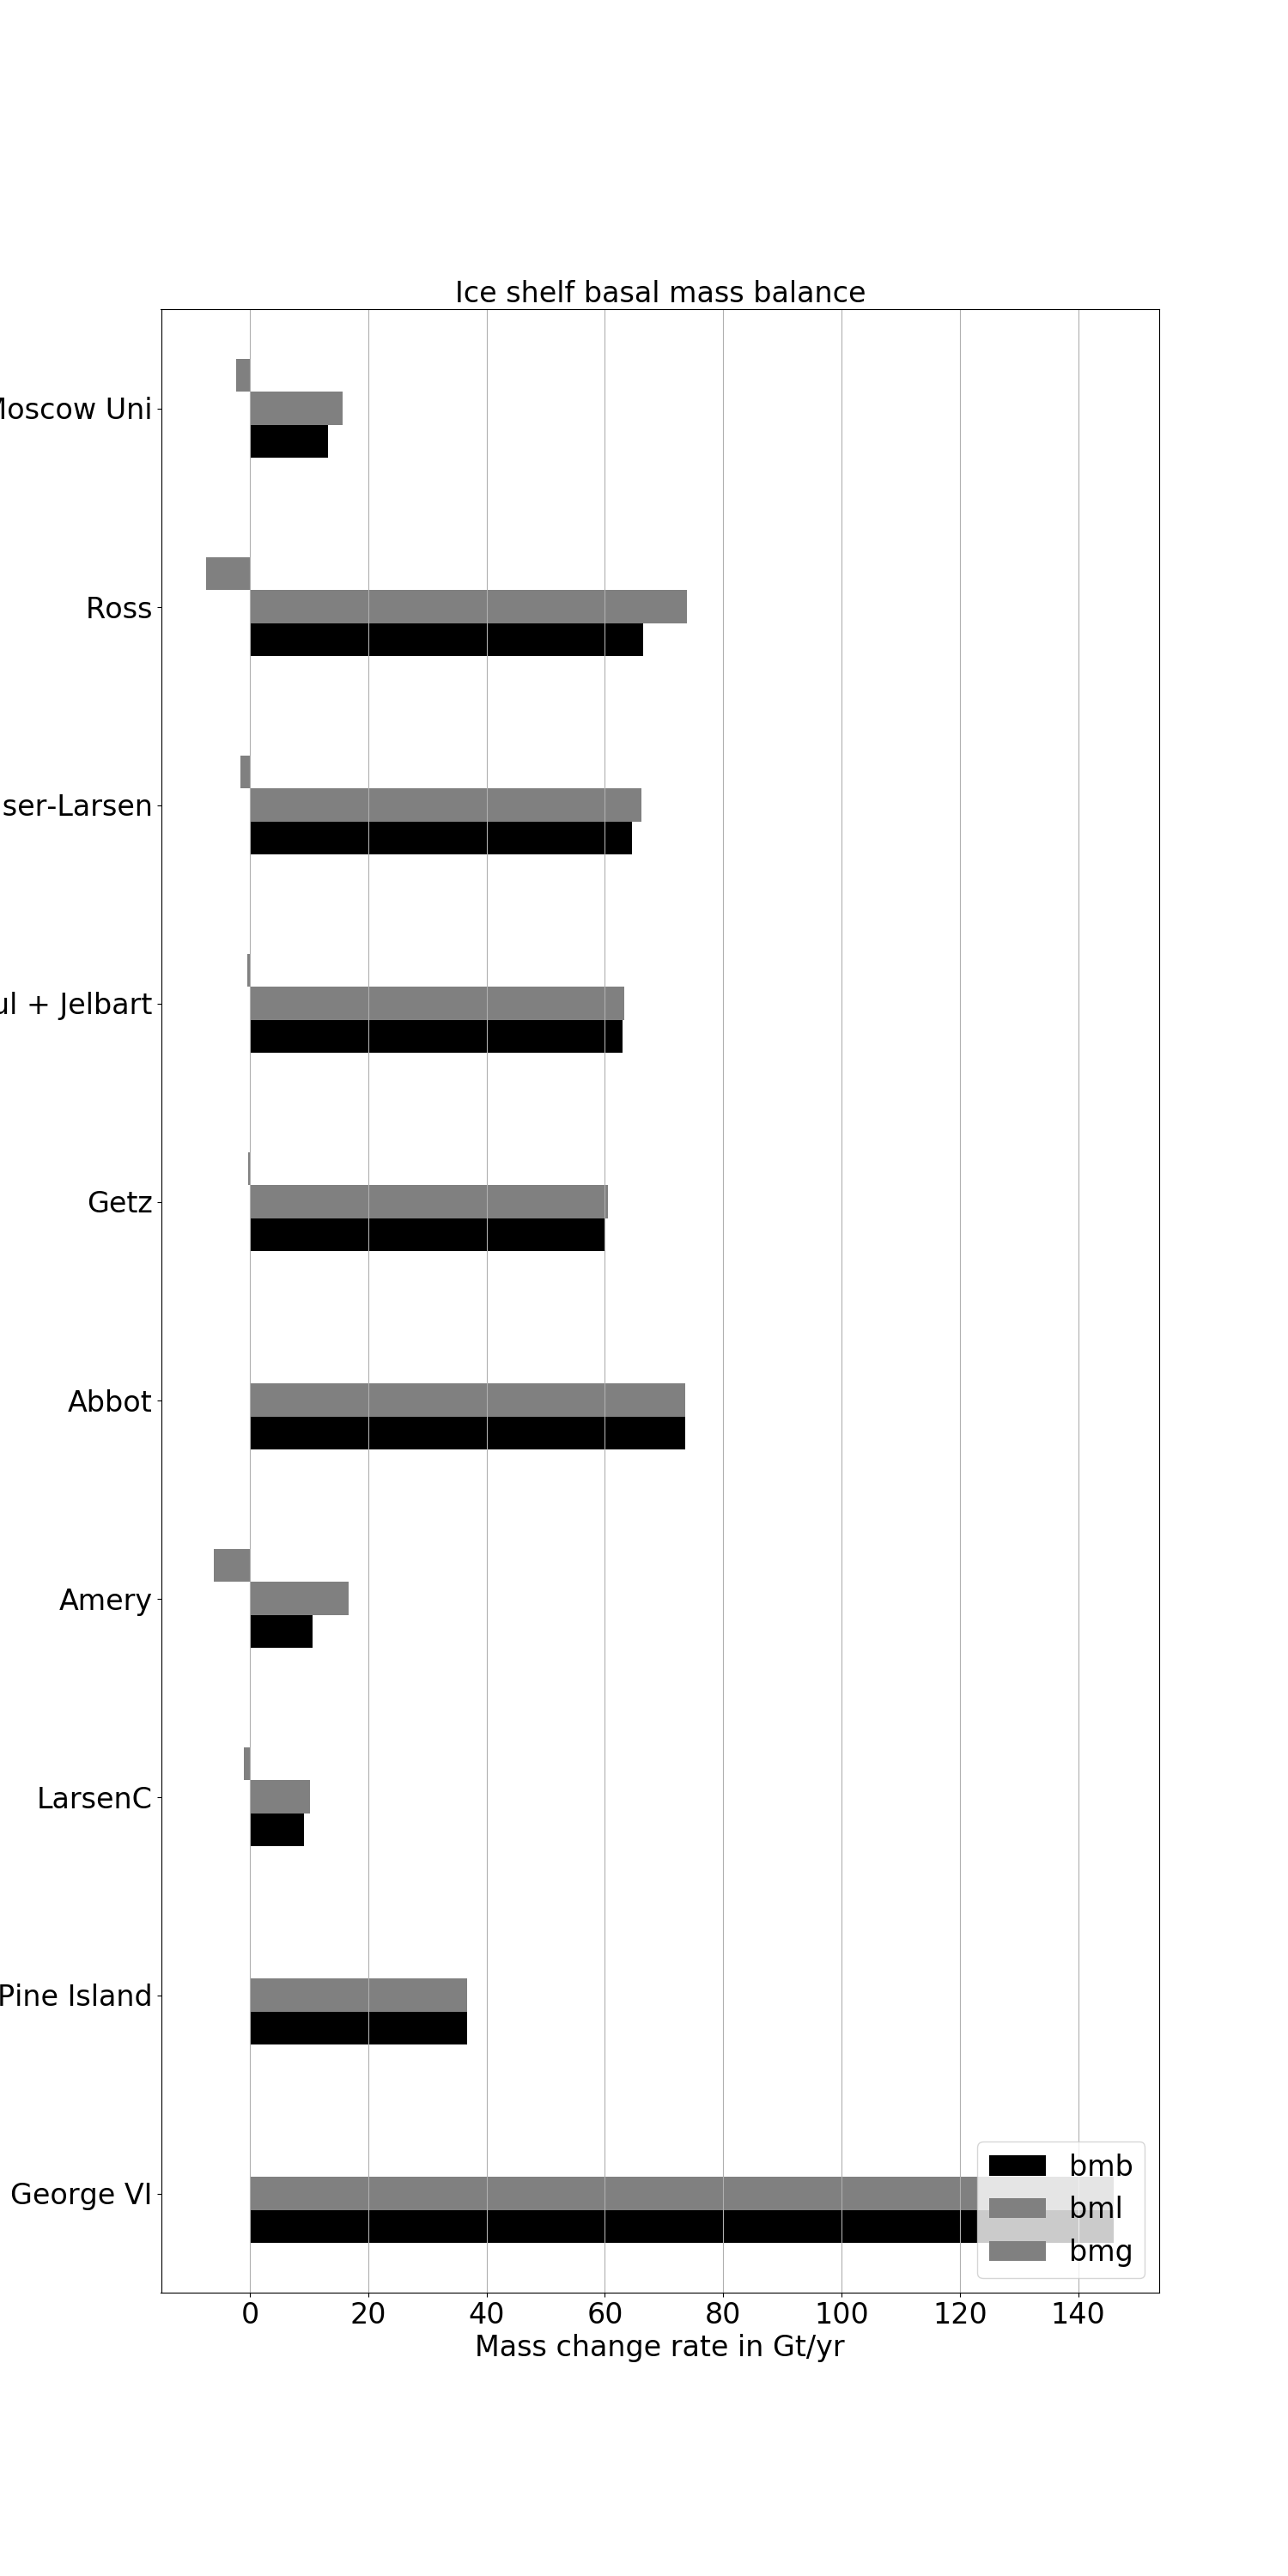

In [104]:
out_path = os.path.join(fig_dir,'bmb2_select.png')

plt.close()
fig,ax = plt.subplots(figsize=(15,30))
df_select.plot(y=['bmb','bml','bmg'],kind='barh',ax=ax,fontsize=24,color=['black','gray','gray'])
ax.legend(markerscale=1,fontsize=24,loc=4)
ax.set_title('Ice shelf basal mass balance',fontsize=24)
ax.set_xlabel('Mass change rate in Gt/yr',fontsize=24)
ax.grid(axis='x')
#plt.savefig(out_path,dpi=300,format='png', bbox_inches='tight')
plt.show()

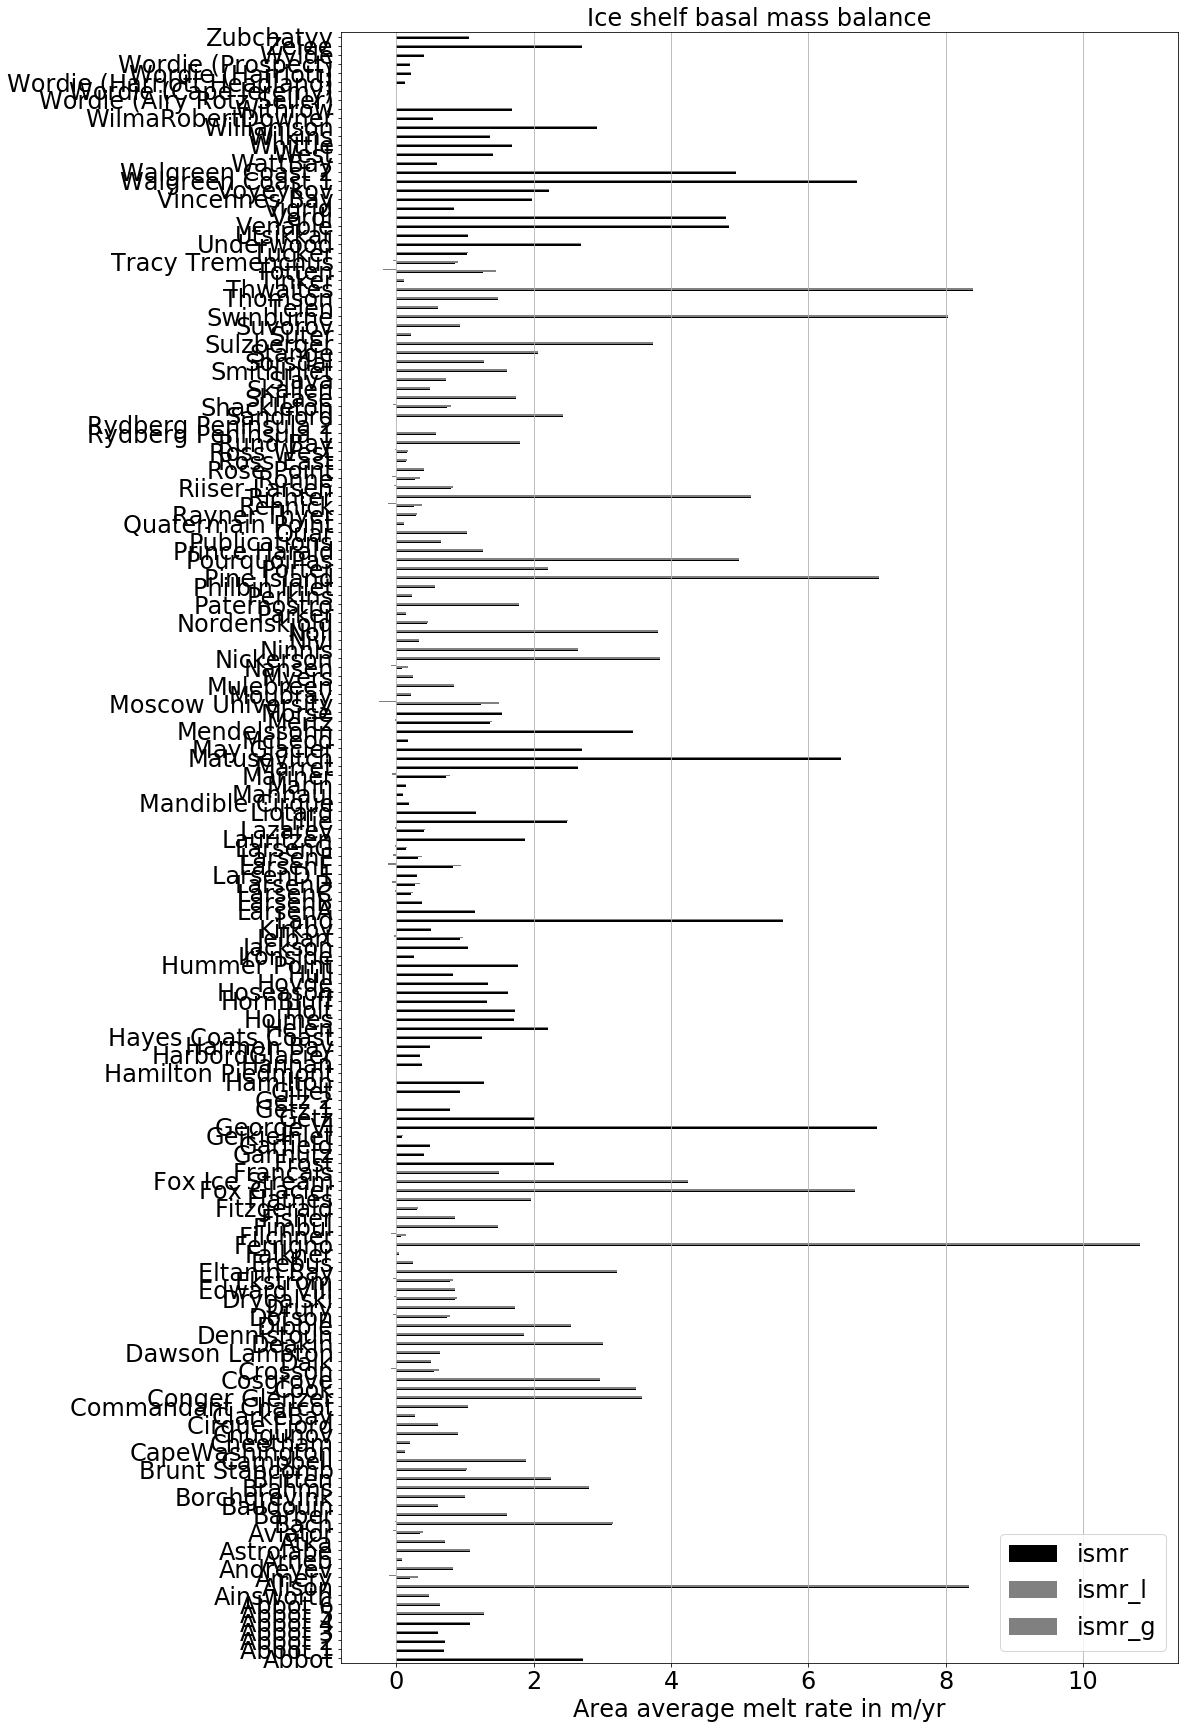

In [31]:
out_path = os.path.join(fig_dir,'ismr_all_2.png')

plt.close()
fig,ax = plt.subplots(figsize=(15,30))
df.plot(y=['ismr','ismr_l','ismr_g'],kind='barh',ax=ax,fontsize=24,color=['black','gray','gray'])
ax.legend(markerscale=1,fontsize=24,loc=4)
ax.set_title('Ice shelf basal mass balance',fontsize=24)
ax.set_xlabel('Area average melt rate in m/yr',fontsize=24)
ax.grid(axis='x')
plt.savefig(out_path,dpi=300,format='png', bbox_inches='tight')
plt.show()